# Intro to the OpenOA `PlantData` and QA Methods

In this example we will be using the ENGIE open data set for the La Haute Borne wind power plant, and demonstrating how to use the quality assurance (QA) methods in OpenOA to help get this data ready for use with the `PlantData` class. This notebook will walk through the creation of the `project_Engie` module, especially the `prepare()` method that returns either the cleaned data or a `PlantData` object.


## Using ENGIE's open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. 

The series of notebooks in the 'examples' folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the 'examples/data' folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

## Imports

In [1]:
import numpy as np
import pandas as pd
from openoa import PlantData
from openoa.utils import qa
from openoa.utils import pandas_plotting as plot

import project_ENGIE

# Avoid clipping data previews unnecessarily
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [2]:
%load_ext autoreload
%autoreload 2

## Step 1: Load the SCADA data

First we'll need to unzip the data, and read the SCADA data to a pandas `DataFrame` so we can take a look at the data before we can start working with it.

In [3]:
data_path = "data/la_haute_borne"
project_ENGIE.extract_data(data_path)

scada_df = pd.read_csv(f"{data_path}/la-haute-borne-data-2014-2015.csv")

scada_df.head(10)

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001
5,R80736,2014-01-01T01:10:00+01:00,-1.00,511.59000,6.69,-3.34,4.70,181.34000,178.02000
6,R80711,2014-01-01T01:10:00+01:00,-0.93,692.33002,7.68,4.72,4.38,172.77000,177.49001
7,R80721,2014-01-01T01:10:00+01:00,-1.01,457.76001,6.48,-4.93,5.02,179.82001,174.91000
8,R80711,2014-01-01T01:20:00+01:00,-0.93,580.12000,7.35,6.84,4.20,172.77000,179.59000
9,R80721,2014-01-01T01:20:00+01:00,-1.01,396.26001,6.16,-1.94,4.88,179.82001,177.85001


The timestamps in the column `Date_time` show that we have timezone information encoded, and that the data have a 10 minute frequency to them (or "10T" according to the pandas guidance: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

To demonstrate the breadth of data that the QA methods are inteneded to handle this demonstration will step through the data using the current format, and an alternative where the timezone data has been stripped out.

In [4]:
scada_df_tz = scada_df.loc[:, :].copy()  # timezone aware
scada_df_no_tz = scada_df.loc[:, :].copy()  # timezone unaware

# Remove the timezone information from the timezone unaware example dataframe
scada_df_no_tz['Date_time'] = [f"{el[0:10]} {el[11:19]}" for el in scada_df_no_tz["Date_time"]]

# Show the resulting change
scada_df_no_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01 01:00:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01 01:00:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01 01:00:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01 01:00:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01 01:10:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001


Below, we can see the data types for each of the columns. We should note that the timestamps are not correctly encoded, but are considered as objects at this time

In [5]:
scada_df_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

In [6]:
scada_df_no_tz.dtypes

Wind_turbine_name     object
Date_time             object
Ba_avg               float64
P_avg                float64
Ws_avg               float64
Va_avg               float64
Ot_avg               float64
Ya_avg               float64
Wa_avg               float64
dtype: object

## Step 2: Convert the timestamps to proper timestamp data objects

Using the `qa.convert_datetime_column()` method, we can convert the timestamp data accordingly and insert the UTC-encoded data as an index for both the timezone aware, and timezone unaware data sets.

Under the hood this method does a few helpful items to create the resulting data set:
1) Converts the column "Date_time" to a datetime object
2) Creates the new datetime columns: "Date_time_localized" and "Date_time_utc" for the localized and UTC-encoded datetime objects
3) Sets the UTC timestamp as the index
4) Creates the column "utc_offset" containing the difference between the UTC timestamp and the localized timestamp that will be used to determine if the timestamp is in DST or not.
5) Creates the column "is_dst" indicating if the timestamps are in DST (`True`), or not (`False`) that will be used later when trying to assess time gaps and duplications in the data

Notice that in the resulting data that the data type of the column "Date_time" is successfully made into a localized timestamp in the timezone aware example, but is kept as a non-localized timestamp in the unaware example.

In the below, the "Date_time_utc" column should always remain in UTC time and the "Date_time_localized" column should always remain in the localized time. Conveniently, Pandas provides two methods `tz_convert()` and `tz_localize()` to toggle back and forth between timezones, which will operate on the index of the DataFrame. It is worth noting that the local time could also be UTC, in which case the two columns would be redundant.

The localized time, even when the passed data is unaware, is adjusted using the `local_tz` keyword argument to help normalize the time strings, from which a UTC-based timestamp is created (even when local is also UTC). By calculating the UTC time from the local time, we are able to ascertain DST shifts in the data, and better assess any anomalies that may exist.

However, there may be cases where the timezone is neither encoded (the unaware example), nor known. In the former, we can use the `local_tz` keyword argument that is seen in the code above, but for the latter, this is much more difficult, and the default value of UTC may not be accurate. In this latter case it is useful to try multiple timezones, such as an operating/owner company's headquarters or often the windfarm's location to find a best fit. 

**NEEDS REVIEW**

In the case of using a US-based windfarm, the subclass `WindToolKitQualityControlDiagnosticSuite` can be used to help better match a timezone and the data provided.

In [7]:
scada_df_tz = qa.convert_datetime_column(
    df=scada_df_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=True # Indicate that we can use encoded data to convert between timezones
)
scada_df_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01 01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01 01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01 01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01 01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01 01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00+01:00,2014-01-01 00:10:00+00:00,0 days 01:00:00,False


In [8]:
print(scada_df_tz.index.dtype)
scada_df_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time              datetime64[ns, Europe/Paris]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

In [9]:
scada_df_no_tz = qa.convert_datetime_column(
    df=scada_df_no_tz,
    time_col="Date_time",
    local_tz="Europe/Paris",
    tz_aware=False  # Indicates that we're going to need to make inferences about encoding the timezones
)
scada_df_no_tz.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01 01:00:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00+01:00,2014-01-01 08:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01 01:00:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00+01:00,2014-01-01 08:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01 01:00:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00+01:00,2014-01-01 08:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01 01:00:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00+01:00,2014-01-01 08:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01 01:10:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00+01:00,2014-01-01 08:10:00+00:00,0 days 01:00:00,False


In [10]:
print(scada_df_no_tz.index.dtype)
scada_df_no_tz.dtypes

datetime64[ns, UTC]


Wind_turbine_name                            object
Date_time                            datetime64[ns]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

## Step 3: Dive into the data

Using the `describe` method, which is a thin wrapper for the pandas method shows us the distribution of each of the numeric and time-based data columns. Notice that both instances, below, are identical because they are the same data set.

In [11]:
qa.describe(scada_df_tz)

,count,mean,std,min,25%,50%,75%,max
Ba_avg,417911.0,10.041381,23.249670,-121.26000,-0.99,-0.99000,0.140000,262.609990
P_avg,417911.0,353.610076,430.378700,-17.92000,35.34,192.13000,508.310000,2051.870100
Ws_avg,417911.0,5.447462,2.487332,0.00000,4.10,5.45000,6.770000,19.309999
Va_avg,417911.0,0.113614,23.030714,-179.95000,-5.88,-0.20000,5.900000,179.990010
Ot_avg,417911.0,12.716480,7.613811,-273.20001,7.30,12.52000,17.469999,39.889999
Ya_avg,417911.0,179.902067,93.158043,0.00000,105.19,194.34000,247.399990,360.000000
Wa_avg,417911.0,177.992732,92.448620,0.00000,103.65,191.46001,243.730000,360.000000
utc_offset,420480,0 days 01:34:31.232876712,0 days 00:29:39.449425279,0 days 01:00:00,0 days 01:00:00,0 days 02:00:00,0 days 02:00:00,0 days 02:00:00


In [12]:
qa.describe(scada_df_no_tz)

,count,mean,std,min,25%,50%,75%,max
Ba_avg,417911.0,10.041381,23.249670,-121.26000,-0.99,-0.99000,0.140000,262.609990
P_avg,417911.0,353.610076,430.378700,-17.92000,35.34,192.13000,508.310000,2051.870100
Ws_avg,417911.0,5.447462,2.487332,0.00000,4.10,5.45000,6.770000,19.309999
Va_avg,417911.0,0.113614,23.030714,-179.95000,-5.88,-0.20000,5.900000,179.990010
Ot_avg,417911.0,12.716480,7.613811,-273.20001,7.30,12.52000,17.469999,39.889999
Ya_avg,417911.0,179.902067,93.158043,0.00000,105.19,194.34000,247.399990,360.000000
Wa_avg,417911.0,177.992732,92.448620,0.00000,103.65,191.46001,243.730000,360.000000
utc_offset,420480,0 days 01:34:31.643835616,0 days 00:29:39.386736091,0 days 01:00:00,0 days 01:00:00,0 days 02:00:00,0 days 02:00:00,0 days 02:00:00


### Inspecting the distributions of each column of numerical data

Similar to the above, `column_histograms` is not part of the QA module, but is helpful for reviewing the independent distributions of data within a dataset. Aligning with the table version below, we can see that some distrbiutions, such as "Ws_avg" don't have any outliers, whereas others such as "Ot_avg" do and have very narrow histograms to accommadate this behavior.

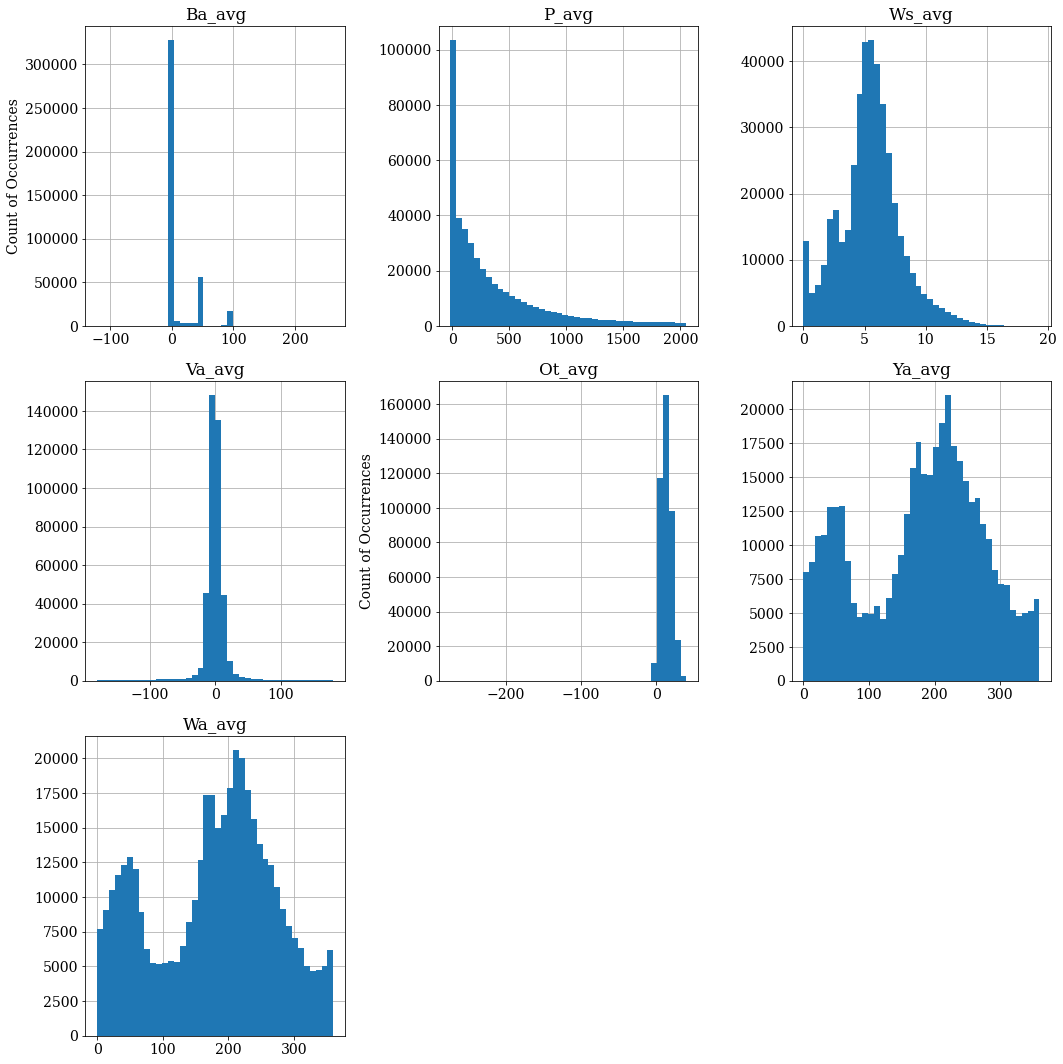

In [13]:
plot.column_histograms(scada_df_tz)

It appears that there are a number of highly frequent values in these distributions, so we can dive into that further to see if we have some unresponsive sensors, in which case the data will need to be invalidated for later analysis. In the below analysis of repeated behaviors in the data, it seems that we should be flagging potentially unresponsive sensors (see Step 5 for more details).

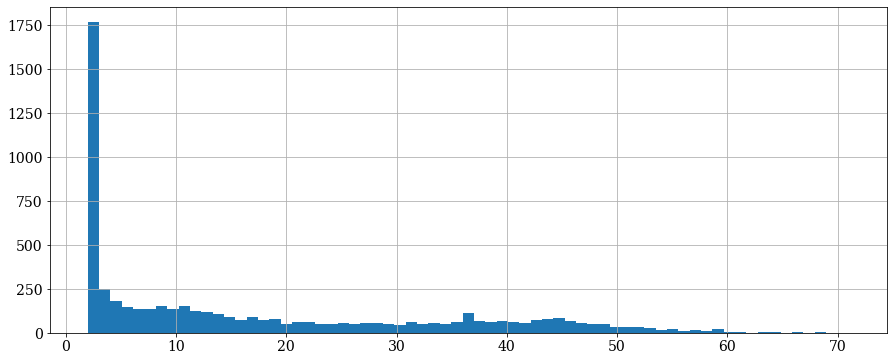

In [71]:
# Only check data for a single turbine to avoid any spurious findings
single_turbine_ix = scada_df_tz.Wind_turbine_name == "R80736"

# Identify consecutive data readings
ix_consecutive = (scada_df_tz.loc[single_turbine_ix].Va_avg.diff(1) != 0)

# Count the number of readings that exist for a specific value when the data are consecutive duplicates
counts = scada_df_tz.loc[single_turbine_ix].loc[ix_consecutive].Va_avg.value_counts()
counts = counts.loc[counts > 1]

# Plot the distribution with the number of bins corresponding the number of unique counts
# to thoroughly inspect the distribution
counts.hist(bins=counts.unique().size);

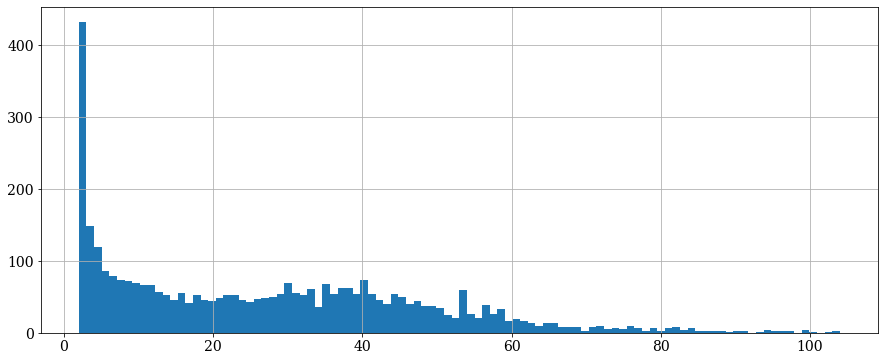

In [72]:
# Identify consecutive data readings
ix_consecutive = (scada_df_tz.loc[single_turbine_ix].Ot_avg.diff(1) != 0)

# Count the number of readings that exist for a specific value when the data are consecutive duplicates
counts = scada_df_tz.loc[single_turbine_ix].loc[ix_consecutive].Ot_avg.value_counts()
counts = counts.loc[counts > 1]

# Plot the distribution with the number of bins corresponding the number of unique counts
# to thoroughly inspect the distribution
counts.hist(bins=counts.unique().size);

### Checking the power curve distributions

While not contained in the QA module, the `plot_by_id` method is helpful for quickly assessing the quality of our operational power curves.

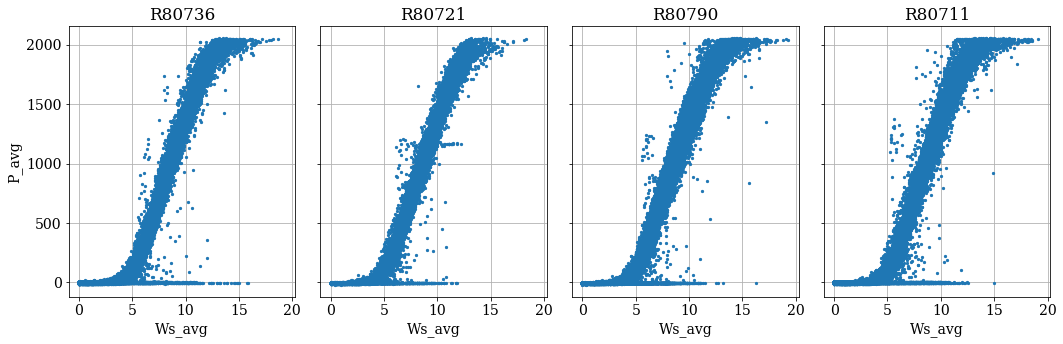

In [14]:
plot.plot_by_id(
    df=scada_df_no_tz,
    id_col="Wind_turbine_name",
    x_axis="Ws_avg",
    y_axis="P_avg",
)

### Inspecting the timestamps for DST gaps and duplications

Now, we can get the the duplicate time stamps from each of the data sets, according to each of the original, localized, and UTC time data. This will help us to compare the effects of DST and timezone encoding.

In the below, timezone unaware data, we can see that there is a significant deviation between the local timestamps and the UTC timestamps, especialy around the end of March in both 2018 and 2019, suggesting that there is something missing with the DST data. 

In [15]:
dup_orig_no_tz, dup_local_no_tz, dup_utc_no_tz = qa.duplicate_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)

In [16]:
dup_orig_tz, dup_local_tz, dup_utc_tz = qa.duplicate_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    id_col="Wind_turbine_name"
)

In [17]:
dup_orig_no_tz.size, dup_local_no_tz.size, dup_utc_no_tz.size

(48, 48, 96)

In [18]:
dup_orig_no_tz

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:50:00+00:00 

In [19]:
dup_utc_no_tz

Date_time_utc
2014-03-09 01:00:00+00:00   2014-03-09 08:00:00+00:00
2014-03-09 01:00:00+00:00   2014-03-09 08:00:00+00:00
2014-03-09 01:00:00+00:00   2014-03-09 08:00:00+00:00
2014-03-09 01:00:00+00:00   2014-03-09 08:00:00+00:00
2014-03-09 01:10:00+00:00   2014-03-09 08:10:00+00:00
2014-03-09 01:10:00+00:00   2014-03-09 08:10:00+00:00
2014-03-09 01:10:00+00:00   2014-03-09 08:10:00+00:00
2014-03-09 01:10:00+00:00   2014-03-09 08:10:00+00:00
2014-03-09 01:20:00+00:00   2014-03-09 08:20:00+00:00
2014-03-09 01:20:00+00:00   2014-03-09 08:20:00+00:00
2014-03-09 01:20:00+00:00   2014-03-09 08:20:00+00:00
2014-03-09 01:20:00+00:00   2014-03-09 08:20:00+00:00
2014-03-09 01:30:00+00:00   2014-03-09 08:30:00+00:00
2014-03-09 01:30:00+00:00   2014-03-09 08:30:00+00:00
2014-03-09 01:30:00+00:00   2014-03-09 08:30:00+00:00
2014-03-09 01:30:00+00:00   2014-03-09 08:30:00+00:00
2014-03-09 01:40:00+00:00   2014-03-09 08:40:00+00:00
2014-03-09 01:40:00+00:00   2014-03-09 08:40:00+00:00
2014-03-09 01:

Now, in the timezone aware data, it is clear that the timezone data is able to fully account for DST, so there aren't any erroneous duplications in the standardized data.

In [20]:
dup_orig_tz.size, dup_local_tz.size, dup_utc_tz.size

(48, 48, 48)

In [21]:
dup_orig_tz

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00+02:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00+02:00
2014-03-30 01:

In [22]:
dup_utc_tz

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:00:00+00:00   2014-03-30 01:00:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:10:00+00:00   2014-03-30 01:10:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:20:00+00:00   2014-03-30 01:20:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:30:00+00:00   2014-03-30 01:30:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:40:00+00:00   2014-03-30 01:40:00+00:00
2014-03-30 01:

To help confirm there are DST corrections needed in the data, we can also take a lot at the gaps in the timestamps, particularly in October. At a quick glance, the timezone unaware UTC encoding seems to create gaps in the data, whereas the timezone-encoded data maintains the existing number of gaps.

In [23]:
gap_orig_no_tz, gap_local_no_tz, gap_utc_no_tz = qa.gap_time_identification(
    df=scada_df_no_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_no_tz.size, gap_local_no_tz.size, gap_utc_no_tz.size

(12, 12, 24)

In [24]:
gap_orig_tz, gap_local_tz, gap_utc_tz = qa.gap_time_identification(
    df=scada_df_tz,
    time_col="Date_time",
    freq="10T"
)
gap_orig_tz.size, gap_local_tz.size, gap_utc_tz.size

(12, 12, 12)

Based on the duplicated timestamps in the timezone unaware data, it does seem like there is a DST correction in spring but no duplicate times in the fall. However, even with a UTC conversion, there still appear to be duplications in the data, so there is likely additional analysis needed here. While it appears that there are time gaps in the data for the original inputs, this phenomena switches seasons to the fall for the UTC converted time stamps, likely due to the lack of timezone encoding in the original inputs compared to a corrected timestamp.

In [25]:
gap_orig_no_tz

12678   2014-03-30 02:00:00
12679   2014-03-30 02:10:00
12680   2014-03-30 02:20:00
12681   2014-03-30 02:30:00
12682   2014-03-30 02:40:00
12683   2014-03-30 02:50:00
65094   2015-03-29 02:00:00
65095   2015-03-29 02:10:00
65096   2015-03-29 02:20:00
65097   2015-03-29 02:30:00
65098   2015-03-29 02:40:00
65099   2015-03-29 02:50:00
dtype: datetime64[ns]

In [26]:
gap_utc_no_tz

12672   2014-03-30 08:00:00+00:00
12673   2014-03-30 08:10:00+00:00
12674   2014-03-30 08:20:00+00:00
12675   2014-03-30 08:30:00+00:00
12676   2014-03-30 08:40:00+00:00
12677   2014-03-30 08:50:00+00:00
43920   2014-11-02 08:00:00+00:00
43921   2014-11-02 08:10:00+00:00
43922   2014-11-02 08:20:00+00:00
43923   2014-11-02 08:30:00+00:00
43924   2014-11-02 08:40:00+00:00
43925   2014-11-02 08:50:00+00:00
65088   2015-03-29 08:00:00+00:00
65089   2015-03-29 08:10:00+00:00
65090   2015-03-29 08:20:00+00:00
65091   2015-03-29 08:30:00+00:00
65092   2015-03-29 08:40:00+00:00
65093   2015-03-29 08:50:00+00:00
96336   2015-11-01 08:00:00+00:00
96337   2015-11-01 08:10:00+00:00
96338   2015-11-01 08:20:00+00:00
96339   2015-11-01 08:30:00+00:00
96340   2015-11-01 08:40:00+00:00
96341   2015-11-01 08:50:00+00:00
dtype: datetime64[ns, UTC]

Based on the duplicated timestamps, it does seem like there is a DST correction in spring and a time gap in the fall. This is in contrast with the timezone unaware counterpart of this example where we found gaps in the spring and none in the fall for the original data, and vice versa for the UTC data. The effect is consistent here because the timezone data is now encoded in the data we are working with, and so the DST shifts are encoded accurately, therefore correctly identifying the fall time gaps that were seen above, and further highlighted in the next piece of this section.

Below, we can observe the effects of having timezones not encoded (first set of plots) versus encoded (second set of plots), and what that might mean for potential analyses. In the unaware data, it appears that the original data (blue, solid line, labeled "Original Timestamp") has a time gap in the spring; however, when we compare it to the UTC timestamp (orange, dashed line), it is clear that there is not in fact any gap in the data, and the DST transition has been encoded properly in the data. On the otherhand, it at first appears that there are no gaps in the fall when we make the same comparison, but when looking at the UTC timestamps, we can see that there is a 1 hour gap in the data for both 2014 and 2015. This is in line with our comparison of the original and UTC time gaps above, and further confirms our findings that there are duplicates in the spring and gaps in the fall.

By having the original data and a UTC-converted timestamp it enables us to see any gaps that may appear when there is no timezone data encoded. On the other hand, using the UTC-converted timestamp does not reduce the number of duplications in this dataset that are present in the spring, but helps adjust for seemingly missing or available data. In tandem we can see in the scatter points that there are still duplicates in the spring data just before the DST switch.

This is all confirmed in the timezone aware example where we can confirm that there are in fact duplications in the spring and gaps in the fall resulting from some issues with the data. Finally, given the DST gap, it's certain this is in the local timezone.

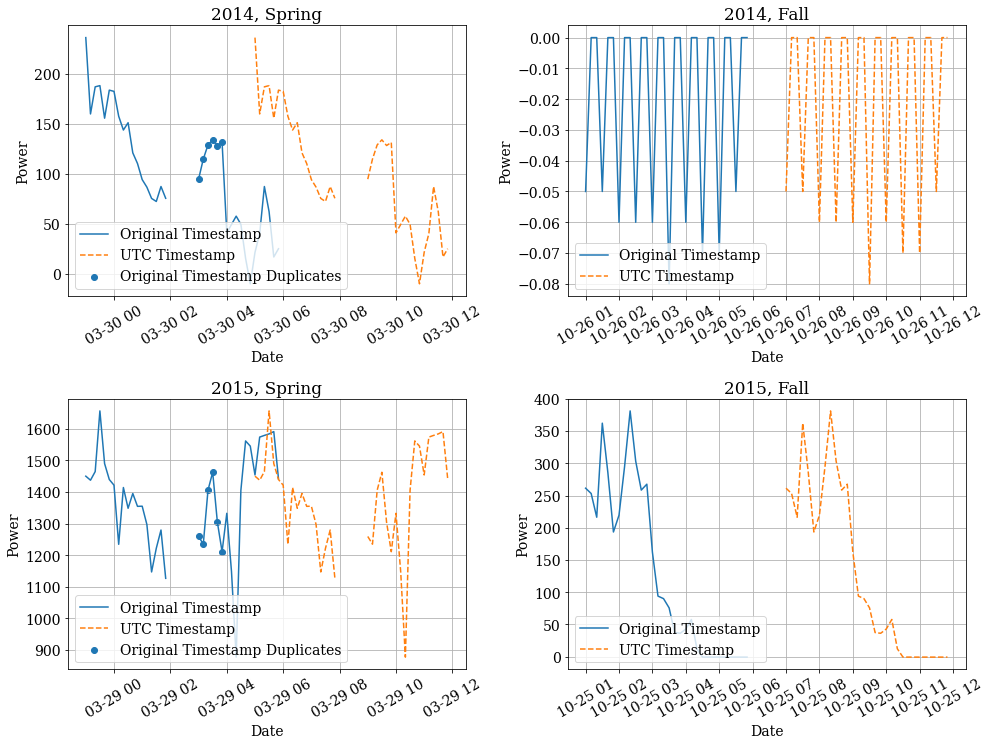

In [27]:
# Timezone Unaware
qa.dalyight_savings_plot(
    df=scada_df_no_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

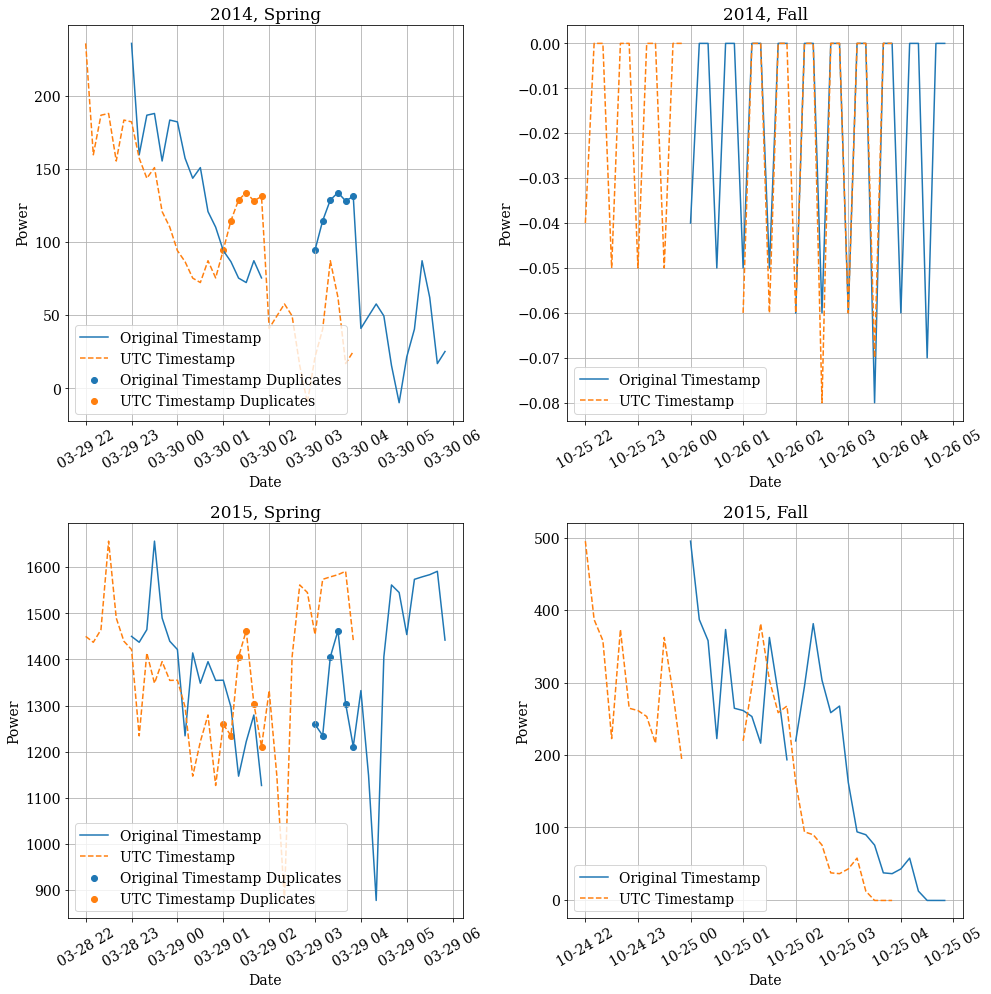

In [28]:
# Timezone Aware
qa.dalyight_savings_plot(
    df=scada_df_tz,
    local_tz="Europe/Paris",
    id_col="Wind_turbine_name",
    time_col="Date_time",
    power_col="P_avg",
    freq="10T",
    hour_window=3  # default value
)

## Step 5: Translating this work into a data loading script for `PlantData`

For 